## References
 - __[Script: Kaggle](https://www.kaggle.com/code/donjoeml/map-of-energy-consumption-in-europe-plotly/notebook)__
 - __[Dataset: Kaggle](https://www.kaggle.com/datasets/donjoeml/energy-consumption-and-generation-in-the-globe/data)__

# Libraries

In [3]:
#Importing the libraries
import pandas as pd
import geopandas as gpd
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import geopandas

# for making gif
# from chart_studio.plotly import image as PlotlyImage
# from PIL import Image as PILImage
# import io
# import chart_studio
import glob
from PIL import Image

# Primary Energy Consumptions (APAC)

In [5]:
# Datasets
df = pd.read_csv('../Python/Input/energy/Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv')

# load the shapefile 
path               = "../Python/Input/ne_110m_admin_0_sovereignty/"
geo_county         = geopandas.read_file(path+'ne_110m_admin_0_sovereignty.shp')
geo_county         = geo_county[['CONTINENT', 'NAME', 'geometry']]

# Merge datasets
df=df.merge(geo_county, how='left', left_on='Entity', right_on='NAME').drop(columns=['NAME'])

# Check for countries with missing continent
df.loc[pd.isna(df.CONTINENT),:].Entity.unique()

# Fix missing continent
df.loc[df.Entity=='North Macedonia','CONTINENT'] = 'Europe'
df.loc[df.Entity=='Hong Kong','CONTINENT']       = 'Asia'
df.loc[df.Entity=='Singapore','CONTINENT']       = 'Asia'
df.loc[df.Entity=='United States','CONTINENT']   = 'North America'

# Check and correct wrongly assign continents
# df.Entity.unique()
df.loc[df.Entity=='Cyprus','CONTINENT'] = 'Europe'

# Double-check for countries with missing continent
# df.loc[pd.isna(df.CONTINENT),:].Entity.unique()

# Keep asian countries
df = df[df['CONTINENT']=='Asia'].reset_index(drop=True)

# Rename the columns
df.rename(columns={
    'Fossil fuels (% sub energy)': 'Fossil',
    'Nuclear (% sub energy)': 'Nuclear',
    'Renewables (% sub energy)': 'Renewables'},inplace=True)

# Show dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454 entries, 0 to 1453
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Entity      1454 non-null   object  
 1   Code        1454 non-null   object  
 2   Year        1454 non-null   int64   
 3   Fossil      1454 non-null   float64 
 4   Renewables  1454 non-null   float64 
 5   Nuclear     1454 non-null   float64 
 6   CONTINENT   1454 non-null   object  
 7   geometry    1344 non-null   geometry
dtypes: float64(3), geometry(1), int64(1), object(3)
memory usage: 91.0+ KB


Entity Code  Year  Fossil  Renewables  Nuclear CONTINENT  \
0  Azerbaijan  AZE  1985  98.445       1.555      0.0      Asia   
1  Azerbaijan  AZE  1986  99.115       0.885      0.0      Asia   
2  Azerbaijan  AZE  1987  99.087       0.913      0.0      Asia   
3  Azerbaijan  AZE  1988  99.208       0.792      0.0      Asia   
4  Azerbaijan  AZE  1989  99.223       0.777      0.0      Asia   

                                            geometry  
0  MULTIPOLYGON (((46.40495 41.86068, 46.68607 41...  
1  MULTIPOLYGON (((46.40495 41.86068, 46.68607 41...  
2  MULTIPOLYGON (((46.40495 41.86068, 46.68607 41...  
3  MULTIPOLYGON (((46.40495 41.86068, 46.68607 41...  
4  MULTIPOLYGON (((46.40495 41.86068, 46.68607 41...

<Axes: >

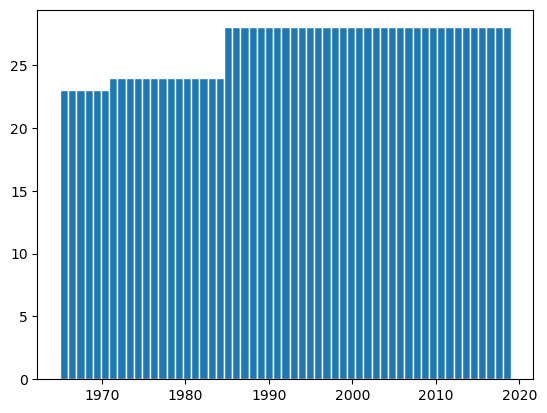

In [6]:
# Check for years data
bins=max(df['Year'])-min(df['Year'])+1
df['Year'].hist(bins=bins, grid=False, ec='white')

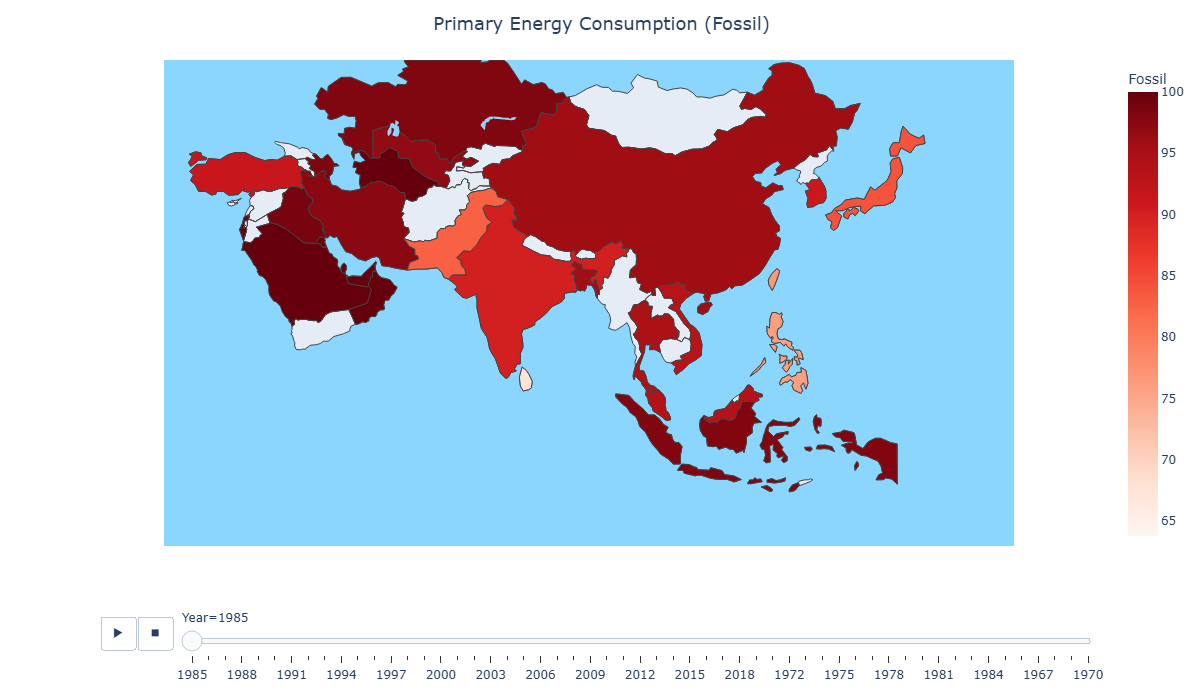

In [7]:
fig = px.choropleth(df,
    locations='Code',
    color='Fossil',
    locationmode='ISO-3',
    animation_frame="Year",
)

fig.update_layout(
    title=dict(
        text='Primary Energy Consumption (Fossil)',
        x=.5,
        font_size=18,
        ),

    geo=dict(
        bgcolor='#8ad6ff',
        lakecolor='#8ad6ff',
        projection_type='miller',
        scope='asia'
        ),
    
    width = 700,
    height = 700,
    coloraxis=dict(colorscale='Reds',cmin=df['Fossil'].min(),cmax=df['Fossil'].max())
)

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 100
fig.show()

In [8]:
fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"type": "choropleth"}, {"type": "choropleth"}], 
                           [{"type": "choropleth"}, {"type": "bar"}]], 
                    subplot_titles=('Nuclear', 'Fossil', 'Renewables','Global Energy Consumption in Europe'))

# create a dataframe for styling
map_ = pd.DataFrame({'Nuclear': [0.45,0.8,'YlOrRd'],
                    'Fossil': [.95,.8,'Greys'],
                    'Renewables': [0.45,0.3,'Greens'],
                     })

for year in range(df['Year'].min(),df['Year'].max()+1):
    layout = dict(
        autosize = False,
        width = 1000,
        height = 1000,
        plot_bgcolor='rgba(0,0,0,0.1)',
        xaxis= {'title': 'Energy source','domain':[0.6, 0.95]},
        yaxis= {'title': 'Share (%)', 'range': [0, 100],'domain':[0.15, 0.45]},
        )
    
    # plot the three maps
    df2 = df[df['Year']==year].reset_index(drop=True)
    r=0
    z=0
    for index, col in enumerate(map_):
    
        geo_key = 'geo'+str(index+1)
    
        fig.add_trace(go.Choropleth(
                locations=df2['Code'],
                z=df2[col].astype(float),
                locationmode='ISO-3',
                colorscale=map_[col][2],
                autocolorscale=False,
                marker_line_color='white',
                geo=geo_key,
                zmin=df[col].min(),
                zmax=df[col].max(),
    
                colorbar=dict(
                    title = '% energy',
                    thickness=10, 
                    x=map_[col][0], 
                    y=map_[col][1],
                    len=0.35),
                    ), 
    
                row=1+r, col=z+1)
    
        z = z+1
        if z==2:
            r = r+1
            z = z-2
    
        layout[geo_key] = dict(
                scope = 'asia',
                projection_type='natural earth',
                domain = dict( x = [], y = [] ),
                lakecolor='#7cd6fc',
                )
    
    
    # position of maps
    z = 0
    COLS = 2
    ROWS = 2
    for y in reversed(range(ROWS)):
        for x in range(COLS):
            geo_key = 'geo'+str(z+1)
            layout[geo_key]['domain']['x'] = [float(x)/float(COLS), float(x+1)/float(COLS)-.03]
            layout[geo_key]['domain']['y'] = [float(y)/float(ROWS), float(y+1)/float(ROWS)]
            z=z+1
            if z > 2:
                break
    
    
    # bar plot
    x1 = ['Nuclear', 'Fossil', 'Renewables']
    y1 = [df2['Nuclear'].mean(), df2['Fossil'].mean(), df2['Renewables'].mean()]
    
    fig.add_trace(go.Bar(
            x=x1, 
            y=y1,
            text=y1,
            texttemplate = '%{text:.2s}%',
            textposition='auto',
            marker_color=['red','black','green'],
            width=.8,
            ), 
            row=2, col=2)
    
    fig.add_annotation(
        text='Source:\
        <a href="https://ourworldindata.org/energy">\
        Our World in Data</a>',    
        xref="paper", 
        yref="paper",
        font_color='black',
        x=0, y=0, 
        showarrow=False)
    
    fig.layout.annotations[0].update(y=0.97)
    fig.layout.annotations[1].update(y=0.97)
    fig.layout.annotations[2].update(y=0.48)
    fig.layout.annotations[3].update(y=0.48)
    
    fig.update_layout(layout)

steps = list()    
j = 0
for i in range(df['Year'].min(),df['Year'].max()+1):
    step = dict(
        method='restyle',
        args=['visible', [False] * 4 * len(df['Year'].unique())], # 4 subplots per year
        label=' {}'.format(i)
    )
    # Set 4 subplots per year to "True"
    step['args'][1][j  ] = True
    step['args'][1][j+1] = True
    step['args'][1][j+2] = True
    step['args'][1][j+3] = True
    j+=4
    steps.append(step)

sliders = [dict(
    steps = steps,
)]

fig.layout.sliders = sliders

fig.show()

### Note
- The original code didn't produce the correct output (sliders don't work). I fixed it. Credits to [Plotly Community: Using One Slider to Control Multiple Subplots](https://community.plotly.com/t/using-one-slider-to-control-multiple-subplots-not-multiple-traces/13955)

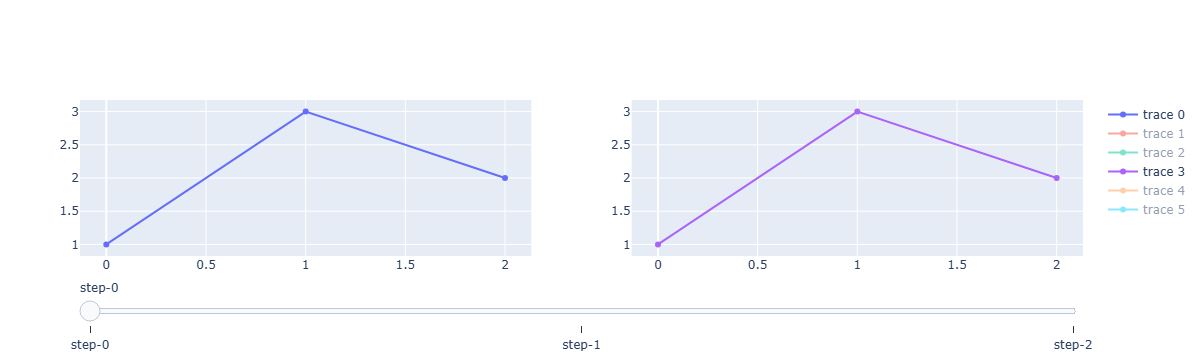

In [10]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(1, 2)

fig.add_scatter(y=[1, 3, 2], row=1, col=1, visible=True)
fig.add_scatter(y=[3, 1, 1.5], row=1, col=1, visible='legendonly')
fig.add_scatter(y=[2, 2, 1], row=1, col=1, visible='legendonly')
fig.add_scatter(y=[1, 3, 2], row=1, col=2, visible=True)
fig.add_scatter(y=[1.5, 2, 2.5], row=1, col=2, visible='legendonly')
fig.add_scatter(y=[2.5, 1.2, 2.9], row=1, col=2, visible='legendonly')

steps = []
for i in range(3):
    step = dict(
        method = 'restyle',  
        args = ['visible', ['legendonly'] * len(fig.data)],
    )
    step['args'][1][i] = True
    step['args'][1][i+3] = True
    steps.append(step)

sliders = [dict(
    steps = steps,
)]

fig.layout.sliders = sliders

fig.show()

# Shift from Fossil Energy to Renewables and Nuclear Energy 
The method I used to quantify the shift toward around source is: \
**-fossil x (renewable - nuclear)** \
where the bold states the slope of linear regression fit from 1965 to present.

In [12]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

regr = LinearRegression()

list_=df['Entity'].unique()
dff = pd.DataFrame(index=range(len(list_)),columns=["Entity", "R/F",'continent'])

for l in range(len(list_)):
    df3=df[df['Entity']==list_[l]]

    Y=['Nuclear','Fossil','Renewables']
    X = df3[['Year']]

    z = np.zeros(3)
    for i in range(len(Y)):
        y=df3[[Y[i]]]
        regr.fit(X, y)
        z[i]=regr.coef_


    out2=-z[1]*(z[2]-z[0])
    
    dff.at[l,'Entity'] = list_[l]
    dff.at[l,'R/F'] = out2
    dff.at[l,'continent'] = 'Asia'
    
dff['R/F'] = pd.to_numeric(dff['R/F'])

C:\Users\U S E R\AppData\Local\Temp\ipykernel_968\3637213043.py:20: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\U S E R\AppData\Local\Temp\ipykernel_968\3637213043.py:20: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\U S E R\AppData\Local\Temp\ipykernel_968\3637213043.py:20: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\U S E R\AppData\Local\Temp\ipykernel_968\3637213043.py:20: DeprecationWarning:

Conversion of an array with ndim > 0 t

In [13]:
dff

Entity           R/F continent
0             Azerbaijan  3.972671e-03      Asia
1             Bangladesh  8.311169e-03      Asia
2                  China  1.566344e-02      Asia
3              Hong Kong  2.036804e-06      Asia
4                  India  1.172171e-02      Asia
5              Indonesia  7.773033e-04      Asia
6                   Iran  4.634135e-03      Asia
7                   Iraq  3.678370e-04      Asia
8                 Israel  3.413864e-04      Asia
9                  Japan -1.404588e-02      Asia
10            Kazakhstan  7.651685e-04      Asia
11                Kuwait  1.439179e-07      Asia
12              Malaysia  2.436751e-03      Asia
13                  Oman  6.017712e-10      Asia
14              Pakistan  3.696145e-05      Asia
15           Philippines  2.415824e-02      Asia
16                 Qatar  8.046841e-07      Asia
17          Saudi Arabia  1.731304e-07      Asia
18             Singapore  3.256077e-05      Asia
19           South Korea -8.877935e-02      Asia
20             Sri Lanka  3.593933e-03      Asia
21                Taiwan  4.945382e-03      Asia
22              Thailand  7.845243e-03      Asia
23                Turkey  1.497670e-02      Asia
24          Turkmenistan  1.885068e-09      Asia
25  United Arab Emirates  6.901804e-06      Asia
26            Uzbekistan  3.987020e-05      Asia
27               Vietnam  1.708897e-01      Asia

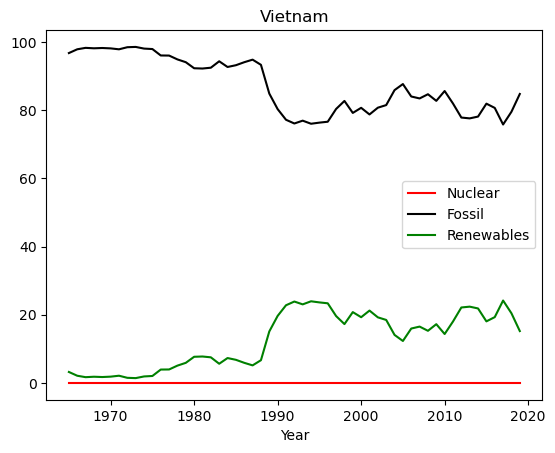

In [14]:
df3=df[df['Entity']==dff['Entity'].iloc[dff['R/F'].idxmax()]]
df3.plot.line(x='Year', y=['Nuclear','Fossil','Renewables'],
              title=dff['Entity'].iloc[dff['R/F'].idxmax()],
              color=['r','k','g'])
plt.show()

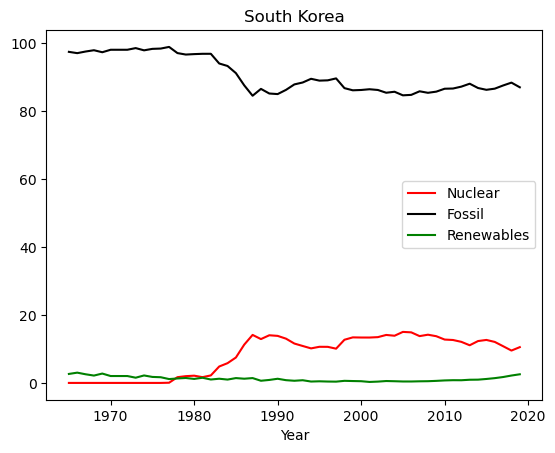

In [15]:
df3=df[df['Entity']==dff['Entity'].iloc[dff['R/F'].idxmin()]]
df3.plot.line(x='Year', y=['Nuclear','Fossil','Renewables'],
              title=dff['Entity'].iloc[dff['R/F'].idxmin()],
              color=['r','k','g'])
plt.show()

In [16]:
fig = make_subplots(rows=2, cols=2, 
                        specs=[[{"type": "bar"}, {"type": "bar"}], 
                               [{"type": "treemap", "colspan": 2}, None]], 
                        subplot_titles=('South Korea', 'Vietnam', 
                                        '% Shift from fossil energy to low-carbon sources'
                                        ))
    
for year in range(df['Year'].min(),df['Year'].max()+1):
    layout = dict(
        autosize = False,
        width = 1000,
        height = 1000,
        plot_bgcolor='rgba(0,0,0,0.1)',
        showlegend=False,
        xaxis= {'title': 'Energy source','domain':[0, 0.45]},
        yaxis= {'title': 'Share (%)', 'range': [0, 100],'domain':[0.55, 1]},
        xaxis2= {'title': 'Energy source','domain':[0.55, 1]},
        yaxis2= {'title': 'Share (%)', 'range': [0, 100],'domain':[0.55, 1]},
        )

    # first bar
    df2 = df[df['Year']==year].reset_index(drop=True)
    df3=df2[df2['Entity']=='South Korea']
    x1 = ['Nuclear', 'Fossil', 'Renewables']
    y1 = [df3['Nuclear'].mean(), df3['Fossil'].mean(), df3['Renewables'].mean()]
    fig.add_trace(go.Bar(
                x=x1, y=y1,
                text=y1,
                texttemplate = '%{text:.2s}%',
                textposition='auto',
                marker_color=['red','black','green'],
                width=.8,
            ), row=1, col=1)


    # second bar
    df3=df2[df2['Entity']=='Vietnam']
    x1 = ['Nuclear', 'Fossil', 'Renewables']
    y1 = [df3['Nuclear'].mean(), df3['Fossil'].mean(), df3['Renewables'].mean()]
    fig.add_trace(go.Bar(
                x=x1, y=y1,
                text=y1,
                texttemplate = '%{text:.2s}%',
                textposition='auto',
                marker_color=['red','black','green'],
                width=.8,
            ), row=1, col=2)

    fig.add_trace(go.Treemap(
        labels=dff['Entity'].to_list(),
        parents=dff['continent'].to_list(),
        values=dff['R/F'].abs().to_list(),
        branchvalues='total',
        marker=dict(
            colors=dff['R/F'].to_list(),
            colorscale=["darkred",'white', "darkgreen"],
            cmid=0),
        ), row=2, col=1)

    fig.update_layout(layout)

    fig.add_annotation(
        text='Source:\
        <a href="https://ourworldindata.org/energy">\
        Our World in Data</a>',    
        xref="paper", 
        yref="paper",
        font_color='black',
        x=0, y=-0.05, 
        showarrow=False)

steps = list()    
j = 0
for i in range(df['Year'].min(),df['Year'].max()+1):
    step = dict(
        method='restyle',
        args=['visible', [False] * 3 * len(df['Year'].unique())], # 3 subplots per year
        label=' {}'.format(i)
    )
    # Set 3 subplots per year to "True"
    step['args'][1][j  ] = True
    step['args'][1][j+1] = True
    step['args'][1][j+2] = True
    j+=3
    steps.append(step)

sliders = [dict(
    steps = steps,
)]

fig.layout.sliders = sliders

fig.show()

## Note
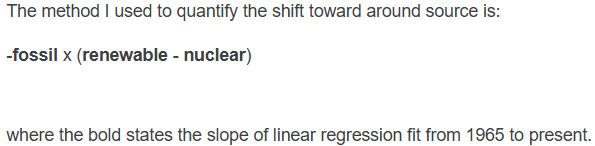 \
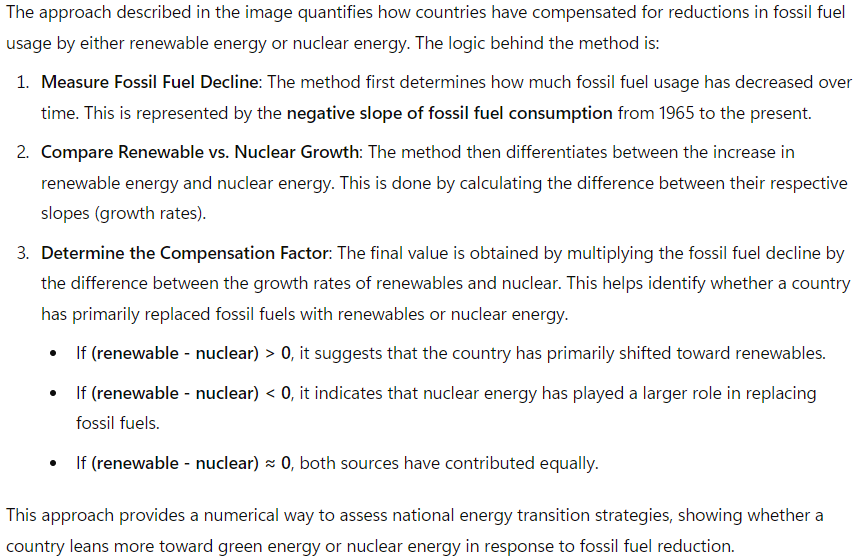 \

# Power Plants Geolocation (APAC)

In [43]:
# import data
df = pd.read_csv('../Python/Input/energy/global_power_plant_database_last.csv')

# keep only desired columns
df = df[['country_long','latitude','longitude','primary_fuel','estimated_generation_gwh_2017']]

# load the shapefile 
path               = "../Python/Input/ne_110m_admin_0_sovereignty/"
geo_county         = geopandas.read_file(path+'ne_110m_admin_0_sovereignty.shp')
geo_county         = geo_county[['CONTINENT', 'NAME', 'geometry']]

# Merge datasets
df=df.merge(geo_county, how='left', left_on='country_long', right_on='NAME').drop(columns=['NAME'])

# Check for countries with missing continent
df.loc[pd.isna(df.CONTINENT),:].country_long.unique()

# Fix missing continent
# df.loc[df.Entity=='North Macedonia','CONTINENT'] = 'Europe'
continent_map = {'Bahrain':'Asia','Singapore':'Asia','Palestine':'Asia','Syrian Arab Republic':'Asia','Brunei Darussalam':'Asia'}
for country_, continent_ in continent_map.items():
    df.loc[df.country_long==country_, 'CONTINENT'] = continent_

# Check for countries with missing continent
df.loc[pd.isna(df.CONTINENT),:].country_long.unique()

# keep asian countries
df = df[df['CONTINENT']=='Asia'].reset_index(drop=True)

# Check missing values
df.isna().sum()

# remove them
df=df.dropna()
df.head()

# # show datasets
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8167 entries, 0 to 8329
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   country_long                   8167 non-null   object  
 1   latitude                       8167 non-null   float64 
 2   longitude                      8167 non-null   float64 
 3   primary_fuel                   8167 non-null   object  
 4   estimated_generation_gwh_2017  8167 non-null   float64 
 5   CONTINENT                      8167 non-null   object  
 6   geometry                       8167 non-null   geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 510.4+ KB


C:\Users\U S E R\AppData\Local\Temp\ipykernel_968\3101376856.py:2: DtypeWarning:

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.



country_long  latitude  longitude primary_fuel  \
0  Afghanistan    32.322    65.1190        Hydro   
1  Afghanistan    31.670    65.7950        Solar   
2  Afghanistan    31.623    65.7920        Solar   
3  Afghanistan    34.556    69.4787        Hydro   
4  Afghanistan    34.641    69.7170        Hydro   

   estimated_generation_gwh_2017 CONTINENT  \
0                         119.50      Asia   
1                          18.29      Asia   
2                          18.72      Asia   
3                         174.91      Asia   
4                         350.80      Asia   

                                            geometry  
0  POLYGON ((66.51861 37.36278, 67.07578 37.35614...  
1  POLYGON ((66.51861 37.36278, 67.07578 37.35614...  
2  POLYGON ((66.51861 37.36278, 67.07578 37.35614...  
3  POLYGON ((66.51861 37.36278, 67.07578 37.35614...  
4  POLYGON ((66.51861 37.36278, 67.07578 37.35614...

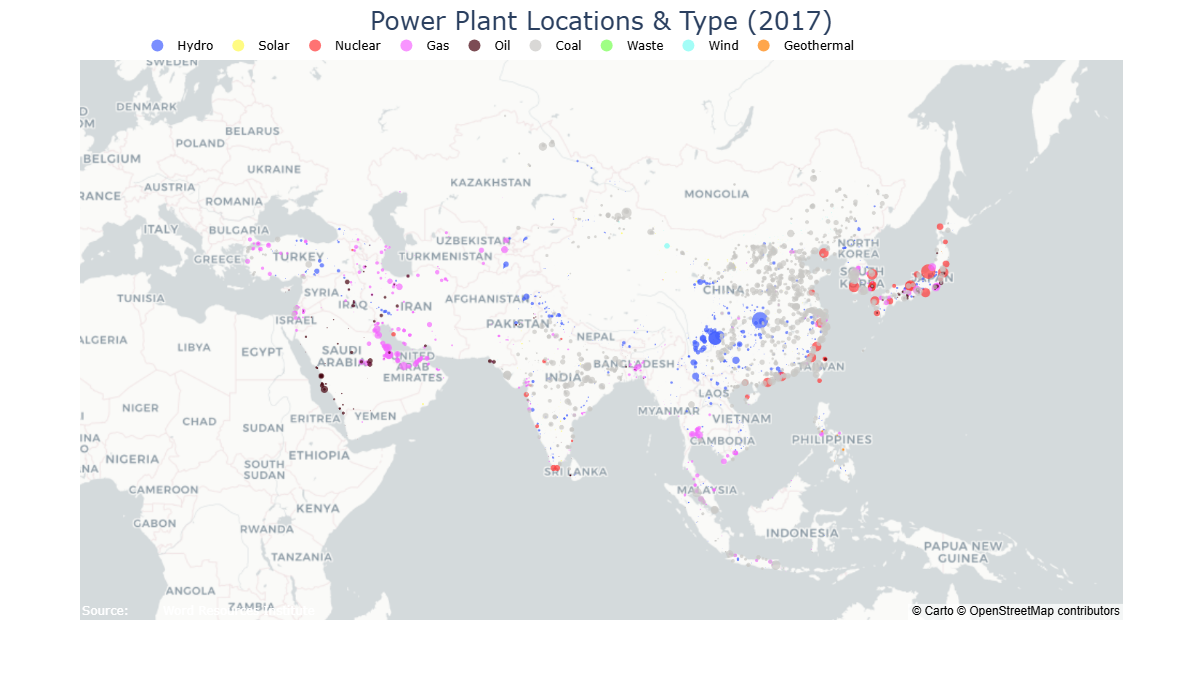

In [147]:
color_discrete_map ={
    'Hydro':'#425fff',
    'Gas':'#f569ff',
    'Wind':'#7cfcf4',
    'Solar':'#fff94d',
    'Oil':'#45010c',
    'Waste':'#77ff52',
    'Nuclear':'#ff3838',
    'Coal':'#c9c8c5',
    'Geothermal':'#ff8000',
    'Other':'#82ffaa'
    }

fig = px.scatter_mapbox(df, 
                        lat="latitude", 
                        lon="longitude", 
                        color="primary_fuel", 
                        size="estimated_generation_gwh_2017",
                        size_max=12, 
                        color_discrete_map = color_discrete_map)

fig.update_layout(
    # mapbox_style="dark",
    mapbox_style="carto-positron",
    showlegend=True,
    
    # legend=dict(
    #         # x=.04,
    #         # y=.96,
    #         title='Type',
    #         title_font_color='black',
    #         bgcolor='rgba(0,0,0,0)',
    #         font_color='black',
    #         ),
    
    legend=dict(
            x=.055,
            y=1,
            orientation="h",
            yanchor="bottom",
            title='',
            title_font_color='black',
            bgcolor='rgba(0,0,0,0)',
            font_color='black',
            ),
    
    mapbox=dict(
            bearing=0,
            center=go.layout.mapbox.Center(lat=28, lon=85),
            zoom=2.1,
                ),
    
    title=dict(
            text='Power Plant Locations & Type (2017)',
            x=.5,
            font_size=25,
                ),
            width=1000,
            height=700,
    )


fig.add_annotation(
    text='Source:\
    <a href="https://datasets.wri.org/dataset/globalpowerplantdatabase">\
    Word Resources Institute</a>',
    xref="paper", 
    yref="paper",
    font_color='white',
    x=0, y=0, 
    showarrow=False)

# fig.write_image('results/Location-types-of-power-plant-in-Europe-2017.jpg',scale=2)
fig.show()

# Energy Consumption/Production (APAC)

In [193]:
# import data
df = pd.read_csv('../Python/Input/energy/share-energy-consum-by-source.csv')

# load the shapefile 
path               = "../Python/Input/ne_110m_admin_0_sovereignty/"
geo_county         = geopandas.read_file(path+'ne_110m_admin_0_sovereignty.shp')
geo_county         = geo_county[['CONTINENT', 'NAME', 'geometry']]

# Merge datasets
df=df.merge(geo_county, how='left', left_on='Entity', right_on='NAME').drop(columns=['NAME'])

# # Check for countries with missing continent
df.loc[pd.isna(df.CONTINENT),:].Entity.unique()

# Fix missing continent
# df.loc[df.Entity=='North Macedonia','CONTINENT'] = 'Europe'
continent_map = {'Hong Kong':'Asia','Singapore':'Asia'}
for country_, continent_ in continent_map.items():
    df.loc[df.Entity==country_, 'CONTINENT'] = continent_

# # Check for countries with missing continent
df.loc[pd.isna(df.CONTINENT),:].Entity.unique()

# # keep asian countries
df = df[df['CONTINENT']=='Asia'].reset_index(drop=True)

# rename the columns
df.rename(columns={
    'Oil (% sub energy)': 'Oil',
    'Coal (% sub energy)': 'Coal',
    'Solar (% sub energy)': 'Solar',
    'Nuclear (% sub energy)': 'Nuclear',
    'Hydro (% sub energy)': 'Hydro',
    'Wind (% sub energy)': 'Wind',
    'Gas (% sub energy)': 'Gas',
    'Other renewables (% sub energy)': 'Other renewables',
    }, inplace=True)

# Check sum of share of energy source (should be 100%; some cases are ~99.9% which requires modification)
fuel_type=['Oil', 'Coal', 'Solar', 'Nuclear', 'Hydro', 'Wind', 'Gas']

df['Other renewables'] = 100 - df[fuel_type].sum(axis=1)

# if the values of 'other renewables' is negative, correct them.
index_=df.index[df['Other renewables']<0]
for i in range(len(index_)):
    df.at[index_[i],'Oil'] = df['Oil'].iloc[index_[i]]+df['Other renewables'].iloc[index_[i]]
    df.at[index_[i],'Other renewables'] = 0
    
# show datasets
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Entity            1509 non-null   object  
 1   Code              1509 non-null   object  
 2   Year              1509 non-null   int64   
 3   Oil               1509 non-null   float64 
 4   Coal              1509 non-null   float64 
 5   Solar             1509 non-null   float64 
 6   Nuclear           1509 non-null   float64 
 7   Hydro             1509 non-null   float64 
 8   Wind              1509 non-null   float64 
 9   Gas               1509 non-null   float64 
 10  Other renewables  1509 non-null   float64 
 11  CONTINENT         1509 non-null   object  
 12  geometry          1399 non-null   geometry
dtypes: float64(8), geometry(1), int64(1), object(3)
memory usage: 153.4+ KB


Entity Code  Year     Oil   Coal  Solar  Nuclear  Hydro  Wind     Gas  \
0  Azerbaijan  AZE  1985  41.444  0.456    0.0      0.0  1.555   0.0  56.545   
1  Azerbaijan  AZE  1986  40.331  0.424    0.0      0.0  0.885   0.0  58.360   
2  Azerbaijan  AZE  1987  39.170  0.437    0.0      0.0  0.913   0.0  59.479   
3  Azerbaijan  AZE  1988  40.083  0.437    0.0      0.0  0.792   0.0  58.687   
4  Azerbaijan  AZE  1989  38.328  0.429    0.0      0.0  0.777   0.0  60.466   

   Other renewables CONTINENT  \
0             0.000      Asia   
1             0.000      Asia   
2             0.001      Asia   
3             0.001      Asia   
4             0.000      Asia   

                                            geometry  
0  MULTIPOLYGON (((46.40495 41.86068, 46.68607 41...  
1  MULTIPOLYGON (((46.40495 41.86068, 46.68607 41...  
2  MULTIPOLYGON (((46.40495 41.86068, 46.68607 41...  
3  MULTIPOLYGON (((46.40495 41.86068, 46.68607 41...  
4  MULTIPOLYGON (((46.40495 41.86068, 46.68607 41...

In [217]:
# list of desired columns, year span, unique countries, energy sources
columns   = ['Country','Year','fuel_type','fuel_type_val']
list_     = df['Entity'].unique()
years     = df['Year'].unique()
fuel_type = ['Oil', 'Coal', 'Solar', 'Nuclear', 'Hydro', 'Wind', 'Gas', 'Other renewables']

# prealocate the number of rows of new datafram
index=len(df)*len(fuel_type)

# create the dataframe
df_new=pd.DataFrame(index=range(index),columns=columns)

# insert the values from the old df
z=0
for i in range(len(df)):
    for f in range(len(fuel_type)):
        df_new.at[z,'Country'] = df['Entity'].iloc[i]
        df_new.at[z,'Year'] = df['Year'].iloc[i]
        df_new.at[z,'fuel_type'] = fuel_type[f]
        df_new.at[z,'fuel_type_val'] = df[fuel_type[f]].iloc[i]
        z=z+1

# filter only data for 2019
df_new=df_new[df_new['Year']==2019]

# create a map of colorcodes for each energy source
color_discrete_map ={
    'Hydro':'#425fff',
    'Gas':'#f569ff',
    'Wind':'#7cfcf4',
    'Solar':'#fff94d',
    'Oil':'#45010c',
    'Nuclear':'#ff3838',
    'Coal':'#c9c8c5',
    'Other renewables':'#82ffaa',
    '(?)':'#b1bbc9',}

# show datasets
df_new.info()
df_new.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 232 entries, 272 to 12071
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Country        232 non-null    object
 1   Year           232 non-null    object
 2   fuel_type      232 non-null    object
 3   fuel_type_val  232 non-null    object
dtypes: object(4)
memory usage: 9.1+ KB


Country  Year         fuel_type fuel_type_val
272  Azerbaijan  2019               Oil        32.788
273  Azerbaijan  2019              Coal         0.008
274  Azerbaijan  2019             Solar          0.06
275  Azerbaijan  2019           Nuclear           0.0
276  Azerbaijan  2019             Hydro         2.127
277  Azerbaijan  2019              Wind         0.183
278  Azerbaijan  2019               Gas        64.724
279  Azerbaijan  2019  Other renewables          0.11
664  Bangladesh  2019               Oil        20.808
665  Bangladesh  2019              Coal         8.209

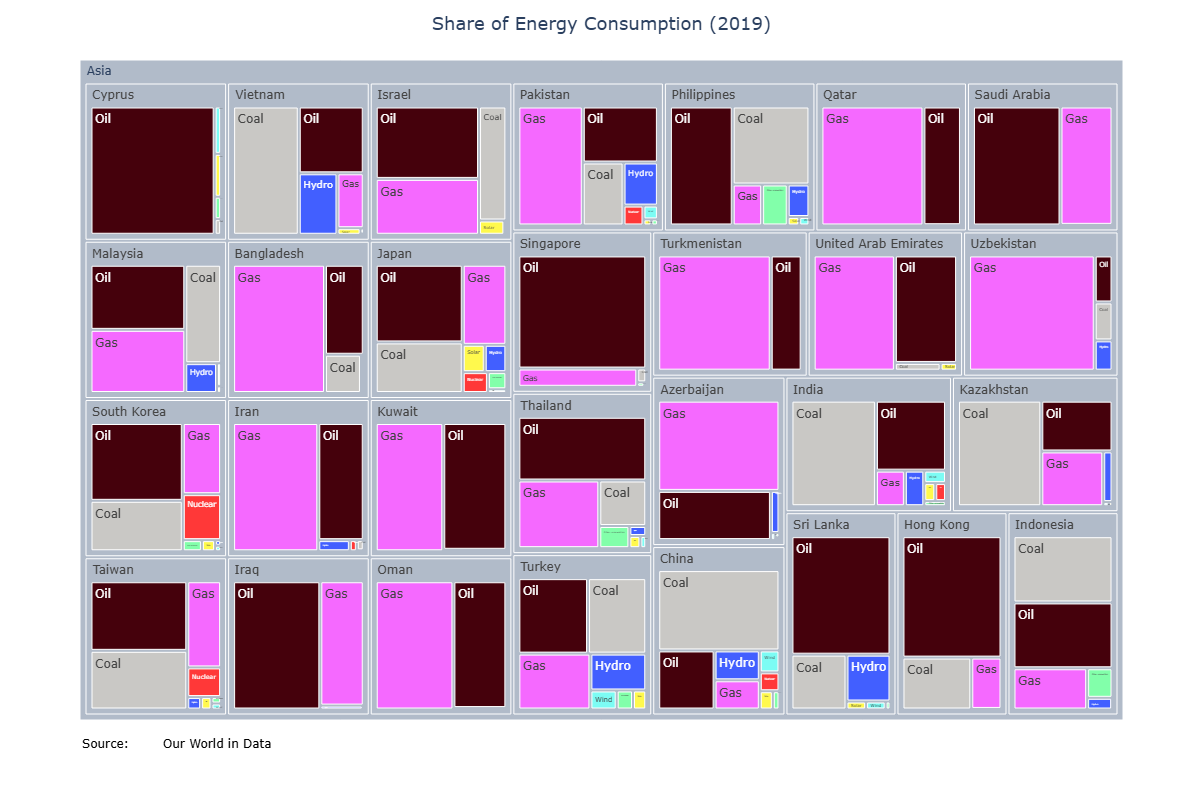

In [219]:
fig = px.treemap(
    df_new, path=[px.Constant('Asia'),'Country', 'fuel_type'], 
    values='fuel_type_val',
    color='fuel_type',
    color_discrete_map = color_discrete_map,
    )

fig.update_layout(    
    title=dict(
    text='Share of Energy Consumption (2019)',
    x=.5,
    font_size=18,
        ),
    width=600,
    height=800,
    )

fig.add_annotation(
    text='Source:\
    <a href="https://ourworldindata.org/energy">\
    Our World in Data</a>',    
    xref="paper", 
    yref="paper",
    font_color='black',
    x=0, y=-0.05, 
    showarrow=False)

# fig.write_image('results/energy_consumption_2019.jpg',scale=2)
fig.show()

In [269]:
# import the data
df = pd.read_csv('../Python/Input/energy/share-elec-produc-by-source.csv')

# load the shapefile 
path               = "../Python/Input/ne_110m_admin_0_sovereignty/"
geo_county         = geopandas.read_file(path+'ne_110m_admin_0_sovereignty.shp')
geo_county         = geo_county[['CONTINENT', 'NAME', 'geometry']]

# Merge datasets
df=df.merge(geo_county, how='left', left_on='Entity', right_on='NAME').drop(columns=['NAME'])

# # Check for countries with missing continent
df.loc[pd.isna(df.CONTINENT),:].Entity.unique()

# Fix missing continent
# df.loc[df.Entity=='North Macedonia','CONTINENT'] = 'Europe'
continent_map = {'Bahrain':'Asia','Singapore':'Asia','Macau':'Asia','Palestine':'Asia','Asia Pacific':'Asia','Other Asia & Pacific':'Asia'}
for country_, continent_ in continent_map.items():
    df.loc[df.Entity==country_, 'CONTINENT'] = continent_

# Check for countries with missing continent
df.loc[pd.isna(df.CONTINENT),:].Entity.unique()

# keep asian countries
df = df[df['CONTINENT']=='Asia'].reset_index(drop=True)

# keep the same countries which the data was available in the previous section
df = df[df['Entity'].isin(list_)]

# rename the columns
df.rename(columns={'Oil (% electricity)': 'Oil',
                   'Coal (% electricity)': 'Coal',
                   'Solar (% electricity)': 'Solar',
                   'Nuclear (% electricity)': 'Nuclear',
                   'Hydro (% electricity)': 'Hydro',
                   'Wind (% electricity)': 'Wind',
                   'Gas (% electricity)': 'Gas',
                   'Other renewables (% electricity)': 'Other renewables',
                   },inplace=True)

# normalize the share of energy production to 100%
fuel_type=['Oil', 'Coal', 'Solar', 'Nuclear', 'Hydro', 'Wind', 'Gas']
df['Other renewables'] = 100 - df[fuel_type].sum(axis=1)

# create a new dataframe
columns = ['Country','Year','fuel_type','fuel_type_val']
fuel_type = ['Oil', 'Coal', 'Solar', 'Nuclear', 'Hydro', 'Wind', 'Gas', 'Other renewables']
years=df['Year'].unique()
index=len(df)*len(fuel_type)
df_new=pd.DataFrame(index=range(index),columns=columns)
z=0
for i in range(len(df)):
    for f in range(len(fuel_type)):
        df_new.at[z,'Country'] = df['Entity'].iloc[i]
        df_new.at[z,'Year'] = df['Year'].iloc[i]
        df_new.at[z,'fuel_type'] = fuel_type[f]
        df_new.at[z,'fuel_type_val'] = df[fuel_type[f]].iloc[i]
        z=z+1

# filter only data for 2019
df_new=df_new[df_new['Year']==2019]

# create a map of colorcodes for each energy source
color_discrete_map ={
    'Hydro':'#425fff',
    'Gas':'#f569ff',
    'Wind':'#7cfcf4',
    'Solar':'#fff94d',
    'Oil':'#45010c',
    'Nuclear':'#ff3838',
    'Coal':'#c9c8c5',
    'Other renewables':'#82ffaa',
    '(?)':'#b1bbc9',}

# show datasets
# df.info()
# df.head()
df_new.info()
df_new.head(10)


<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 152 to 7959
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Country        224 non-null    object
 1   Year           224 non-null    object
 2   fuel_type      224 non-null    object
 3   fuel_type_val  224 non-null    object
dtypes: object(4)
memory usage: 8.8+ KB


Country  Year         fuel_type fuel_type_val
152  Azerbaijan  2019               Oil     46.267137
153  Azerbaijan  2019              Coal           0.0
154  Azerbaijan  2019             Solar      0.178891
155  Azerbaijan  2019           Nuclear           0.0
156  Azerbaijan  2019             Hydro      6.299204
157  Azerbaijan  2019              Wind      0.548871
158  Azerbaijan  2019               Gas     46.074357
159  Azerbaijan  2019  Other renewables       0.63154
440  Bangladesh  2019               Oil     21.800587
441  Bangladesh  2019              Coal      2.124707

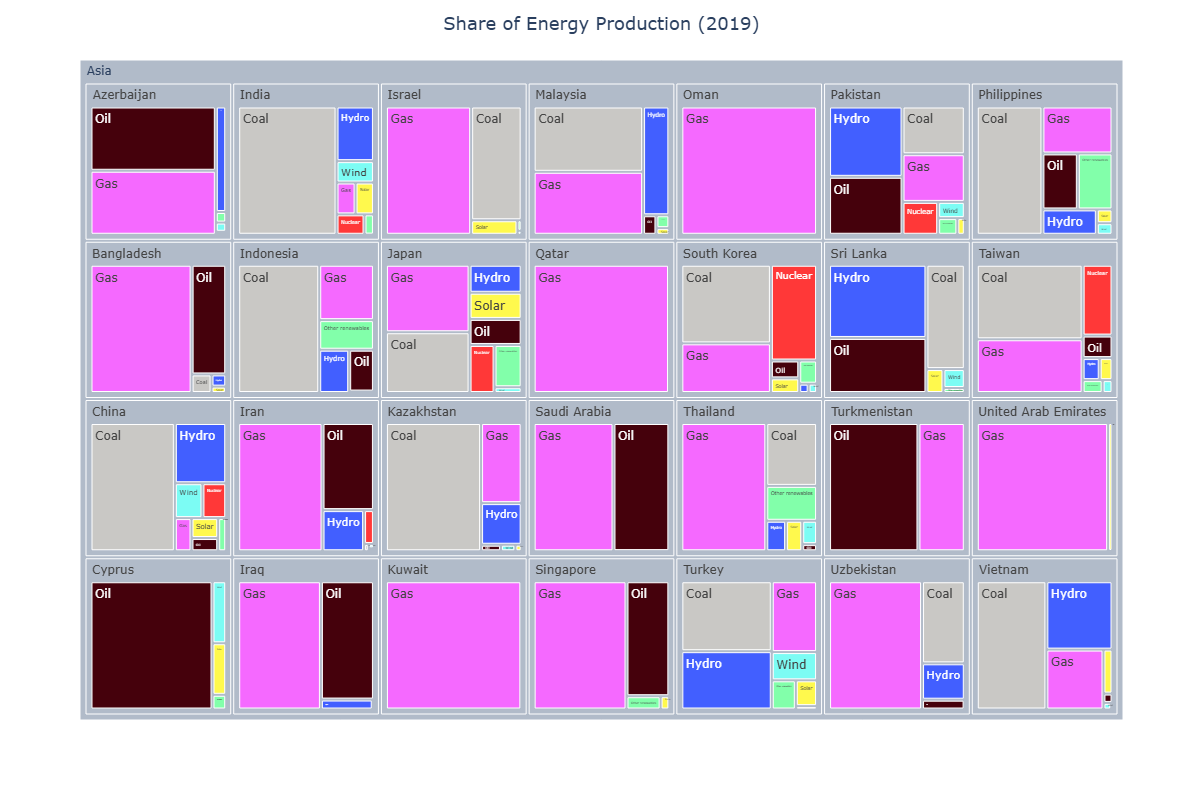

In [273]:
fig = px.treemap(df_new, path=[px.Constant('Asia'),'Country', 'fuel_type'], 
                 values='fuel_type_val',
                 color='fuel_type',
                 color_discrete_map = color_discrete_map,
                 )

fig.update_layout(    
    title=dict(
    text='Share of Energy Production (2019)',
    x=.5,
    font_size=18,
        ),
    width=600,
    height=800,
    )

# fig.write_image('results/energy_production_2019.jpg',scale=2)
fig.show()